# Function

In [49]:
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import random
import h5py
import glob, os, time
import numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
import logging
from PIL import Image
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Model

In [50]:
class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.seen = 0
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat  = [512, 512, 512,256,128,64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat,in_channels = 512,dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        
        if not load_weights:
            mod = models.vgg16(pretrained = True)
            self._initialize_weights()
            
            # orderdict to list
            weight = [lay[1] for lay in mod.state_dict().items()]
            # apply
            for i, layer in enumerate(self.frontend.state_dict().items()):
                layer[1].data[:] = weight[i].data[:]
                
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            
                
def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)                

In [51]:
# model = CSRNet()
# model(torch.FloatTensor(5,3,128,128).zero_()).shape

## Dataset

### augments

In [52]:
class RandomResizedCrop:
    def __init__(self, size, scale):
        self.transform = transforms.RandomResizedCrop(size = size, scale= scale)
        
    def __call__(self, img, hot_map0, hot_map1):
        crop_indices = self.transform.get_params(img, \
                                                 scale = self.transform.scale, \
                                                 ratio = self.transform.ratio)
        i, j, h, w = crop_indices
        return TF.resized_crop(img, i, j, h, w, self.transform.size, self.transform.interpolation),\
                TF.resized_crop(hot_map0, i, j, h, w, self.transform.size, self.transform.interpolation),\
                TF.resized_crop(hot_map1, i, j, h, w, self.transform.size, self.transform.interpolation)

class RandomRotation:
    def __init__(self, max_angle = 90):
        self.max_angle = max_angle
        
    def __call__(self, img, hot_map):
        angle = random.random() * self.max_angle
        return TF.rotate(img, angle), TF.rotate(hot_map, angle)
    
class RandomVFlip:
    def __init__(self):
        pass
    def __call__(self, img, hot_map0, hot_map1):
        return TF.vflip(img), TF.vflip(hot_map0), TF.vflip(hot_map1)

class RandomHFlip:
    def __init__(self):
        pass
    def __call__(self, img, hot_map0, hot_map1):
        return TF.hflip(img), TF.hflip(hot_map0), TF.hflip(hot_map1)

class FixTransforms:
    # apply the same augmentations on both input and gt
    def __init__(self, augmentations, probs):
        self.augmentations = augmentations
        self.probs = probs

    def __call__(self, img, hot_map0, hot_map1):
        # both img, hot_map are PIL
        for i, augmentation in enumerate(self.augmentations):
            if random.random() < self.probs[i]:
                img, hot_map0, hot_map1 = augmentation(img, hot_map0, hot_map1)
        return img, hot_map0, hot_map1

### dataset

In [53]:
class SDD(Dataset):
    def __init__(self, size = 512):
        super(SDD, self).__init__()
        self.file_list = glob.glob('data/raw_v3/*.h5')
        
        self.transform = transforms.Compose([
            transforms.ToTensor(),\
#             transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225]),
        ])

        self.aug = FixTransforms([
            RandomHFlip(),
            RandomVFlip(),
#             RandomRotation(),
            RandomResizedCrop(size = size, scale=(0.7, 1.0)),
#         ],probs = [0,0,0,0])
        ], probs = [0.5, 0.5, 1, 1])
        

    def __getitem__(self, index):
        data = h5py.File(self.file_list[index], 'r')
        xs, ys0, ys1 = np.asarray(data['img']), np.asarray(data['map0']), np.asarray(data['map1'])
        
        xs = TF.to_pil_image(xs)
        ys0 = TF.to_pil_image(ys0)
        ys1 = TF.to_pil_image(ys1)
        
        xs, ys0, ys1 = self.aug(xs, ys0, ys1)
        
        xs = self.transform(xs)
        
        ys0 = TF.resize(ys0, [int(ys0.size[1]/8), int(ys0.size[0]/8)])
        ys0 = TF.to_tensor(ys0)
        ys1 = TF.resize(ys1, [int(ys1.size[1]/8), int(ys1.size[0]/8)])
        ys1 = TF.to_tensor(ys1)

        return xs, ys0, ys1

    def __len__(self):
        return len(self.file_list)
    
class ValSDD(Dataset):
    def __init__(self):
        super(ValSDD, self).__init__()
        self.file_list = glob.glob('data/val/*.h5')
        
        self.transform = transforms.Compose([
            transforms.ToTensor(),\
#             transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225]),
        ])

    def __getitem__(self, index):
        data = h5py.File(self.file_list[index], 'r')
        xs, ys = np.asarray(data['img']), np.asarray(data['map'])
        
        xs = TF.to_pil_image(xs)
        ys = TF.to_pil_image(ys)
        
        xs = self.transform(xs)
        ys = TF.resize(ys, [int(ys.size[1]/8), int(ys.size[0]/8)])
        ys = TF.to_tensor(ys)
        return xs, ys

    def __len__(self):
        return len(self.file_list)
    
class TestData(Dataset):
    def __init__(self):
        super(TestData, self).__init__()
        self.file_list = glob.glob('data/test/*.png')
        
        self.transform = transforms.Compose([
            transforms.ToTensor(),\
#             transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225]),
        ])

    def __getitem__(self, index):
        xs = Image.open(self.file_list[index]).convert('RGB')
        xs = self.transform(xs)
        return xs

    def __len__(self):
        return len(self.file_list)

## eval func

In [57]:
def evalfunc(model, VLoader, criterion, scaling_factor):
    model.eval()
    loss, count = 0, 0
    with torch.no_grad():
        for n_count, (x, y0, y1) in enumerate(VLoader):
            output = model(x.to(device))
            loss += criterion(output, y0.to(device) * scaling_factor)
            count += 1
    model.train()
    return loss/count
    

## test

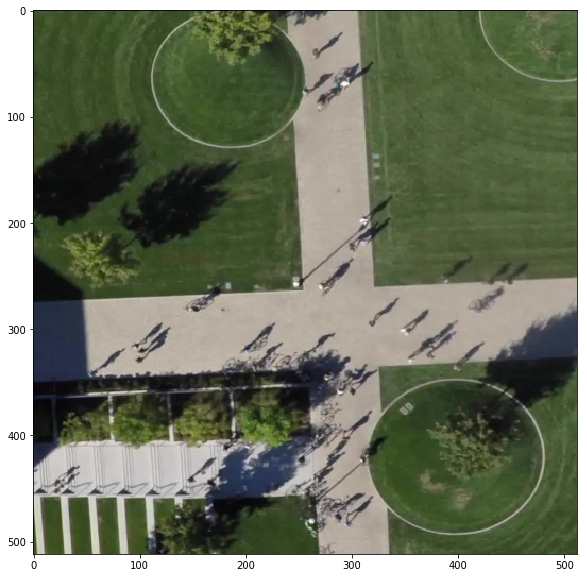

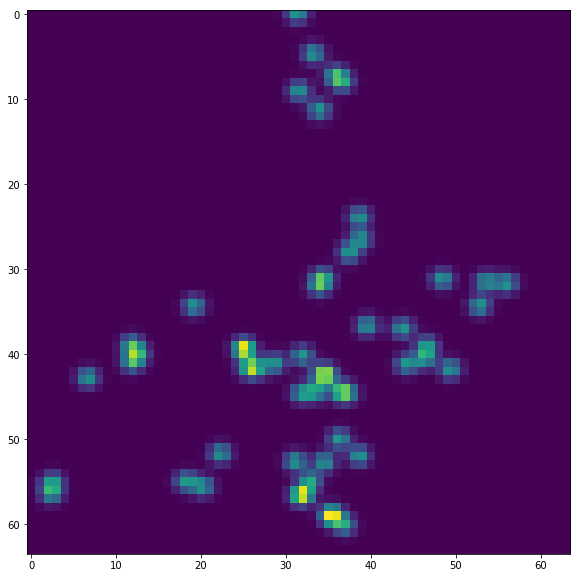

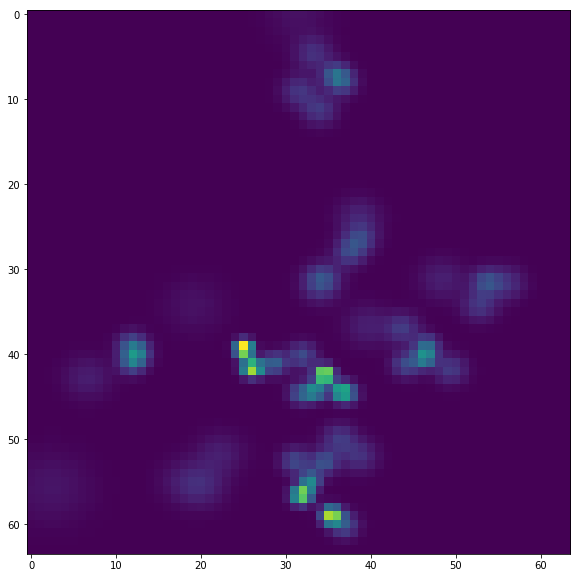

In [55]:
d = SDD(size = 512)
DLoader = DataLoader(dataset = d, num_workers = 4, batch_size = 1, shuffle = True)
for n_count, (x, y0, y1) in enumerate(DLoader):
    break
plt.figure(figsize=(10,10))
plt.imshow(x[0].permute(1,2,0).numpy())
plt.clim(0,1)
plt.figure(figsize=(10,10))
plt.imshow(y0[0,0].numpy()*1e6)
plt.figure(figsize=(10,10))
plt.imshow(y1[0,0].numpy()*1e6)

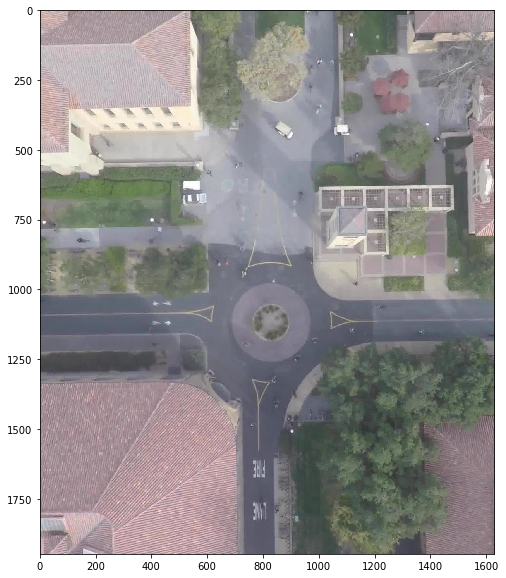

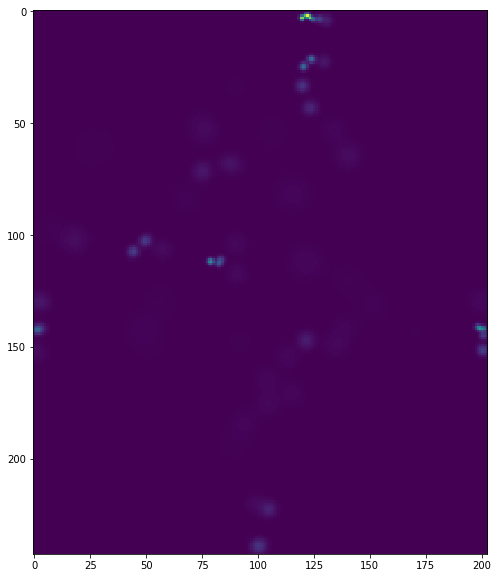

In [56]:
d = ValSDD()
DLoader = DataLoader(dataset = d, num_workers = 1, batch_size = 1, shuffle = True)
for n_count, (x, y) in enumerate(DLoader):
    break
plt.figure(figsize=(10,10))
plt.imshow(x[0].permute(1,2,0).numpy())
plt.clim(0,1)
plt.figure(figsize=(10,10))
plt.imshow(y[0,0].numpy()*1e6)

# Main

In [9]:
n_epoch = 20
batch_size = 16
scaling_factor = 1
lr = 1e-5

# model dir
save_dir = 'model/trial4/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# logger
logger = logging.getLogger()
hdlr = logging.FileHandler(os.path.join(save_dir, 'train.log'))
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
hdlr.setFormatter(formatter)
logger.addHandler(hdlr) 
logger.setLevel(logging.INFO)

# model
model = CSRNet().to(device)
model.train()

# dataset
d = SDD(size = 512)
DLoader = DataLoader(dataset = d, num_workers = 4, batch_size = batch_size, shuffle = True)
v = ValSDD()
VLoader = DataLoader(dataset = v, num_workers = 1, batch_size = 1, shuffle = False)

# criterion
criterion = nn.MSELoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = MultiStepLR(optimizer, milestones=[5,15,25], gamma=0.5)

init_epoch = 0
# init_epoch = findLastCheckpoint(save_dir=save_dir)  # load the last model in matconvnet style
# if init_epoch > 0:
#     print('resuming by loading epoch %03d' % init_epoch)
#     model.load_state_dict(\
#                 torch.load(os.path.join(save_dir, 'model_%03d.pth' % init_epoch))['stat_dict']\
#                           )
#     optimizer.load_state_dict(\
#                 torch.load(os.path.join(save_dir, 'model_%03d.pth' % init_epoch))['op_stat_dict']
#                           )

for epoch in range(init_epoch, n_epoch):
    scheduler.step(epoch)
    
    start_time = time.time()
    start_time2 = time.time()
    for n_count, (x, y0, y1) in enumerate(DLoader):
        
        optimizer.zero_grad()

        output = model(x.to(device))
        loss = criterion(output, y0.to(device) * scaling_factor)
        
        loss.backward()
        optimizer.step()

        if n_count % 10 == 0: 
            if n_count % 80 == 0:
                val_loss = evalfunc(model, VLoader, criterion, scaling_factor)
                info = '%4d %4d / %4d loss = %2.4f eval_loss = %2.4f time = %2.4fsec' % \
                      (epoch+1, n_count, DLoader.__len__(), loss.item()/batch_size, \
                       val_loss, time.time()-start_time)
                logger.info(info)
                print(info)
            else:
                info = '%4d %4d / %4d loss = %2.4f time = %2.4fsec' % \
                      (epoch+1, n_count, DLoader.__len__(), loss.item()/batch_size, \
                       time.time()-start_time)
                logger.info(info)
                print(info)
                start_time = time.time()
        

    elapsed_time = time.time() - start_time
    torch.save({'stat_dict': model.state_dict(), \
                'op_stat_dict': optimizer.state_dict()
               }
               , os.path.join(save_dir, 'model_%03d.pth' % (epoch+1)))

   1    0 /  188 loss = 585.3439 eval_loss = 2383.6018 time = 7.2116sec
   1   10 /  188 loss = 263.4547 time = 19.7948sec
   1   20 /  188 loss = 379.0056 time = 17.2261sec
   1   30 /  188 loss = 435.0325 time = 13.3042sec
   1   40 /  188 loss = 223.7747 time = 20.9037sec
   1   50 /  188 loss = 117.3935 time = 17.2447sec
   1   60 /  188 loss = 498.7708 time = 13.3662sec
   1   70 /  188 loss = 196.0719 time = 20.2309sec
   1   80 /  188 loss = 437.0358 eval_loss = 2448.6843 time = 16.7215sec
   1   90 /  188 loss = 355.4391 time = 37.2215sec
   1  100 /  188 loss = 450.1598 time = 16.2872sec
   1  110 /  188 loss = 435.0950 time = 21.6794sec
   1  120 /  188 loss = 161.3368 time = 14.3116sec
   1  130 /  188 loss = 539.5625 time = 21.8904sec
   1  140 /  188 loss = 667.7501 time = 17.7602sec
   1  150 /  188 loss = 304.1435 time = 19.8365sec
   1  160 /  188 loss = 387.3159 eval_loss = 2256.4802 time = 18.2216sec
   1  170 /  188 loss = 208.2490 time = 35.1325sec
   1  180 /  188 

Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 247, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 247, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


# Evaluation

In [8]:
model = CSRNet().to(device)
model.load_state_dict(torch.load('model/trial3/model_005.pth')['stat_dict'])
# model.load_state_dict(torch.load('model/trial2/model_020.pth')['stat_dict'])
# model.load_state_dict(torch.load('model/trial/model_050.pth')['stat_dict'])

<All keys matched successfully>

In [9]:
dd = TestData()
DD = DataLoader(dataset = dd, num_workers = 1, batch_size = 1, shuffle = False)
model.eval()
for n_count, x in enumerate(DD):
    if n_count < 0:
        continue
    output = model(x.to(device))
    break

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(x[0].permute(1,2,0).cpu().detach().numpy())
plt.clim(0,1)

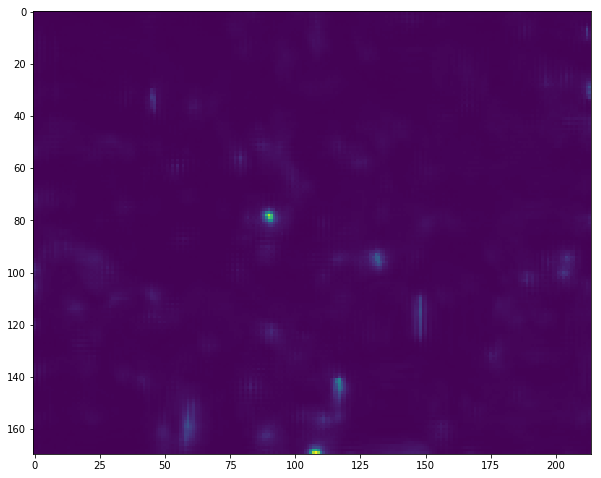

In [40]:
plt.figure(figsize=(10,10))
plt.imshow(output[0,0].cpu().detach().numpy())

In [32]:
for n_count, x in enumerate(DD):
    if n_count < 1:
        continue
    output = model(x.to(device))
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


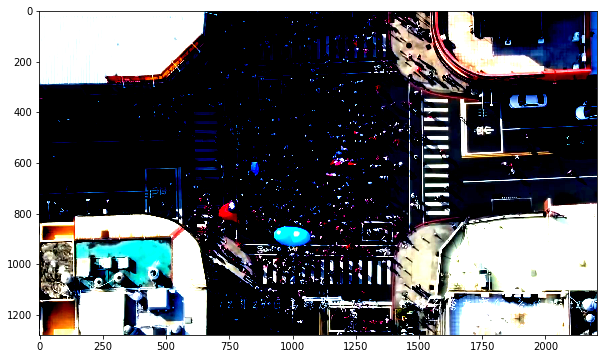

In [34]:
plt.figure(figsize=(10,10))
plt.imshow(x[0].permute(1,2,0).cpu().detach().numpy())
plt.clim(0,1)

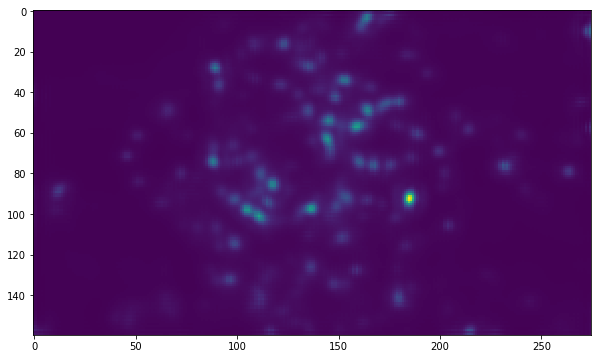

In [33]:
plt.figure(figsize=(10,10))
plt.imshow(output[0,0].cpu().detach().numpy())

# Backup

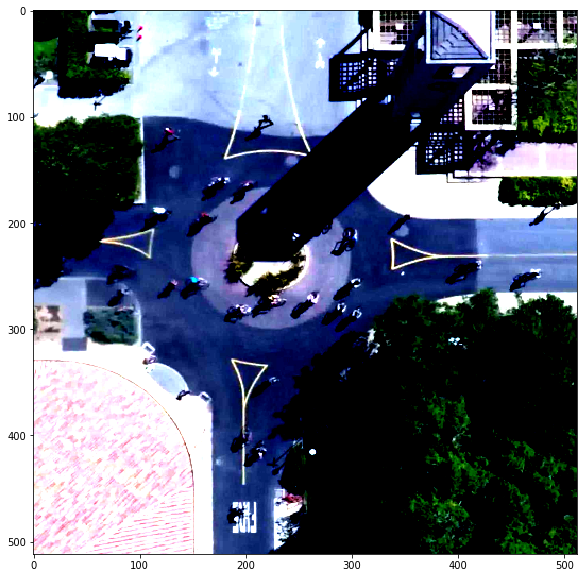

In [98]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(x[0].permute(1,2,0).numpy())
plt.clim(0,1)


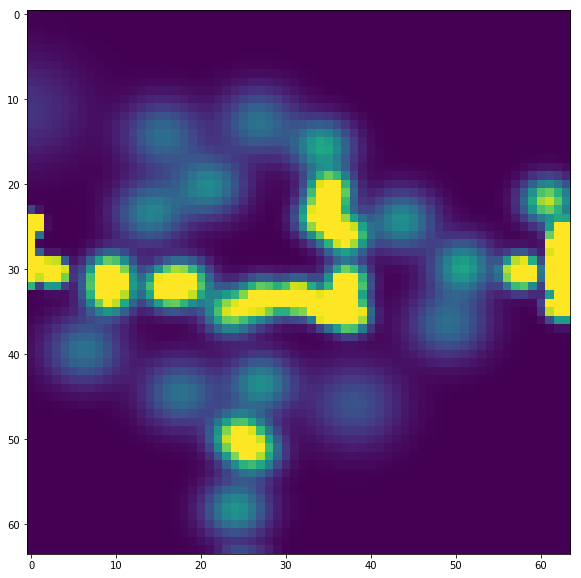

In [99]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(y[0,0,...].numpy()*10000)
plt.clim(0,1)